# Importing libraries

In [135]:
from statsbombpy import sb #pip install statsbombpy
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore') # temporary

# Exploring competions

In [2]:
competitions_df = sb.competitions()

competitions_df.head()

,competition_id,season_id,country_name,competition_name,competition_gender,competition_youth,competition_international,season_name,match_updated,match_updated_360,match_available_360,match_available
0,16,4,Europe,Champions League,male,False,False,2018/2019,2022-12-01T11:42:34.874323,2021-06-13T16:17:31.694,None,2022-12-01T11:42:34.874323
1,16,1,Europe,Champions League,male,False,False,2017/2018,2021-08-27T11:26:39.802832,2021-06-13T16:17:31.694,None,2021-01-23T21:55:30.425330
2,16,2,Europe,Champions League,male,False,False,2016/2017,2021-08-27T11:26:39.802832,2021-06-13T16:17:31.694,None,2020-07-29T05:00
3,16,27,Europe,Champions League,male,False,False,2015/2016,2021-08-27T11:26:39.802832,2021-06-13T16:17:31.694,None,2020-07-29T05:00
4,16,26,Europe,Champions League,male,False,False,2014/2015,2021-08-27T11:26:39.802832,2021-06-13T16:17:31.694,None,2020-07-29T05:00


In [3]:
print('Competions dataframe columns:')
print(competitions_df.columns.tolist())

print('Competitions names:')
print(competitions_df.competition_name.unique())

# The focus of this project is La Liga, so we need the competion id
la_liga_name = 'La Liga'
la_liga_id = competitions_df.query(f'competition_name == "{la_liga_name}"')['competition_id'].iloc[0]
print(f'\nLa Liga competion_id is {la_liga_id}')


Competions dataframe columns:
['competition_id', 'season_id', 'country_name', 'competition_name', 'competition_gender', 'competition_youth', 'competition_international', 'season_name', 'match_updated', 'match_updated_360', 'match_available_360', 'match_available']
Competitions names:
['Champions League' "FA Women's Super League" 'FIFA World Cup'
 'Indian Super league' 'La Liga' 'NWSL' 'Premier League' 'UEFA Euro'
 "UEFA Women's Euro" "Women's World Cup"]

La Liga competion_id is 11


# La Liga seasons exploring

In [4]:
# We need the season_id for each la liga season
print(f'\nLa Liga competion_id is: {la_liga_id}')

seasons_id_list = []

seasons_id_list = competitions_df.query(f'competition_id == {la_liga_id}').season_id.tolist()

print(f'Total seasons of La Liga covered from StatsBomb API: {len(seasons_id_list)}')


La Liga competion_id is: 11
Total seasons of La Liga covered from StatsBomb API: 17


# Collect match data for all sesons

In [97]:
# For how many matches we have information about?
class Season_La_liga():
    def __init__(self, id, name, matches_df):
        self.id = id
        self.name = name
        self.matches_df = matches_df

        self.matches_id_list = self.matches_df.match_id.tolist()

seasons_messi = []

for season in seasons_id_list:
    matches_info_df = sb.matches(competition_id=la_liga_id, season_id=season)
    
    total_season_matches = matches_info_df.shape[0]
    season_name = matches_info_df.season.iloc[0]

    seasons_messi.append(Season_La_liga(season, season_name, matches_info_df))


# Exploring avaliable columns
print(seasons_messi[0].matches_df.columns.tolist())

match_columns_use = ['match_id','match_date', 'season','home_team', 'away_team', 'home_score', 'away_score', 'match_week']

matches_complete_df = pd.DataFrame(columns=match_columns_use)

for messi_season in seasons_messi:
    matches_complete_df = matches_complete_df.append(messi_season.matches_df.loc[:, match_columns_use])

print(matches_complete_df.season.value_counts())

['match_id', 'match_date', 'kick_off', 'competition', 'season', 'home_team', 'away_team', 'home_score', 'away_score', 'match_status', 'match_status_360', 'last_updated', 'last_updated_360', 'match_week', 'competition_stage', 'stadium', 'referee', 'home_managers', 'away_managers', 'data_version', 'shot_fidelity_version', 'xy_fidelity_version']
2014/2015    38
2011/2012    37
2017/2018    36
2020/2021    35
2009/2010    35
2018/2019    34
2016/2017    34
2010/2011    33
2015/2016    33
2019/2020    33
2012/2013    32
2013/2014    31
2008/2009    31
2007/2008    28
2006/2007    26
2005/2006    17
2004/2005     7
Name: season, dtype: int64


# Transforming the match dataframe

In [116]:
matches_complete_df.head()

,match_id,match_date,competition,season,home_team,away_team,home_score,away_score,match_week
6,68353,2004-10-16,Spain - La Liga,2004/2005,Espanyol,Barcelona,0,1,7
1,68313,2004-10-24,Spain - La Liga,2004/2005,Barcelona,Osasuna,3,0,8
0,68314,2004-12-04,Spain - La Liga,2004/2005,Barcelona,Málaga,4,0,14
4,69153,2004-12-11,Spain - La Liga,2004/2005,Albacete,Barcelona,1,2,15
3,68315,2004-12-21,Spain - La Liga,2004/2005,Barcelona,Levante,2,1,17


In [117]:
def transform_match_dataframe(our_team_name, matches_df):
    matches_df['home/away'] = np.where(matches_df['home_team'] == our_team_name, 'home', 'away')

    matches_df['opponent'] = np.where(matches_df['home_team'] == our_team_name, matches_df['away_team'], matches_df['home_team'])

    matches_df['goals_scored'] = np.where(matches_df['home_team'] == our_team_name, matches_df['home_score'], matches_df['away_score'])

    matches_df['goals_conceded'] = np.where(matches_df['home_team'] == our_team_name, matches_df['away_score'], matches_df['home_score'])

    result_conditions = [
    (matches_df['goals_scored'] > matches_df['goals_conceded']),
    (matches_df['goals_scored'] == matches_df['goals_conceded']),
    (matches_df['goals_scored'] < matches_df['goals_conceded'])
]

    result_values = ['w', 'd', 'l']

    matches_df['result'] = np.select(result_conditions, result_values)

    matches_df = matches_df.drop(['home_team', 'away_team', 'home_score', 'away_score'], axis=1)

    matches_df = matches_df.sort_values(by=['match_date'])
    return matches_df

matches_df = transform_match_dataframe('Barcelona', matches_complete_df.copy())

# matches_df.groupby(['home/away', 'result'])['result'].count()

home/away  result
away       d          57
           l          35
           w         166
home       d          29
           l          16
           w         217
Name: result, dtype: int64

## Exploring match dataframe

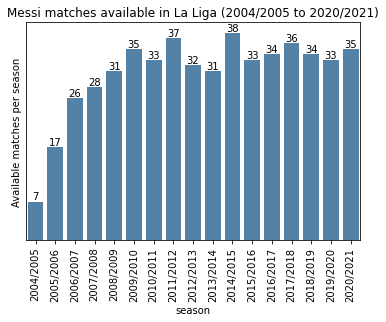

In [181]:
season_match_df = matches_df.groupby('season')[['match_id']].count().reset_index()

ax = sns.barplot(data=season_match_df, x='season', y='match_id', color='steelblue')

plt.xticks(rotation=90);
plt.yticks([])
ax.set_ylabel('Available matches per season')
plt.title('Messi matches available in La Liga (2004/2005 to 2020/2021)')
ax.bar_label(ax.containers[0]);

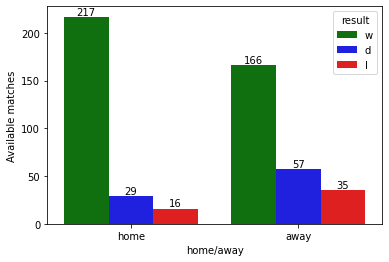

In [202]:
home_away_matches_df = matches_df.groupby(['home/away', 'result'])['match_id'].count().reset_index()

ax = sns.barplot(data=home_away_matches_df, x='home/away', y='match_id', hue='result', order=['home', 'away'], hue_order=['w', 'd', 'l'], palette=['green', 'blue', 'red'])
ax.set_ylabel('Available matches')
for i in range(3):
    ax.bar_label(ax.containers[i]);


# Checking if get the correct match result from shots

In [ ]:
class Score_Match():
    def __init__(self, home_team_name, id, home_score, away_team_name, away_score):
        self.id = id
        self.home_team_name = home_team_name
        self.home_score = home_score
        self.away_team_name = away_team_name
        self.away_score = away_score
    
    def inform_user(self):
        print(f'{self.home_team_name} - {self.away_team_name} : {self.home_score} - {self.away_score}')

def match_score_from_matches_df(match_id_search, matches_df):
    cur_match_df = matches_df.query(f'match_id == {match_id_search}')

    if len(cur_match_df) == 0:
        print(f'Could not find the match with id: {match_id_search}')
        return
    
    score_obj = Score_Match(
        id= match_id_search,
        home_team_name= cur_match_df.home_team.iloc[0],
        home_score=cur_match_df.home_score.iloc[0],
        away_team_name=cur_match_df.away_team.iloc[0],
        away_score=cur_match_df.away_score.iloc[0]
    )

    return score_obj

def confirm_match_score_from_even_df(score_obj:Score_Match, events_df):
    goals_df = events_df.query(f'match_id == {score_obj.id} and shot_outcome == "Goal"')

    home_goal_events = len(goals_df.query(f'possession_team == "{score_obj.home_team_name}"'))
    away_goal_events = len(goals_df.query(f'possession_team == "{score_obj.away_team_name}"'))

    if home_goal_events != score_obj.home_score:
        return False
        
    if away_goal_events != score_obj.away_score:
        return False

    return True

In [63]:
for season_unique in seasons_messi:
    print(f'Season: {season_unique.name}')
    problematic_match_scores = 0
    shots_season_df = sb.competition_events(
        country='Spain',
        season=season_unique.name,
        division='La Liga',
        split=True
    )['shots']

    for match_of_season_id in season_unique.matches_id_list:
        score_match_obj = match_score_from_matches_df(match_of_season_id, season_unique.matches_df)
        # score_match_obj.inform_user()
        
        found_correct_score = confirm_match_score_from_even_df(score_match_obj, shots_season_df)
        if found_correct_score is False:
            problematic_match_scores += 1
            score_match_obj.inform_user()
    print(f'Total problematic scores in season: {problematic_match_scores}')


Season: 2020/2021
Real Betis - Barcelona : 2 - 3
Barcelona - Villarreal : 4 - 0
Celta Vigo - Barcelona : 0 - 3
Deportivo Alavés - Barcelona : 1 - 1
Barcelona - Getafe : 5 - 2
Cádiz - Barcelona : 2 - 1
Barcelona - Deportivo Alavés : 5 - 1
Barcelona - Athletic Club : 2 - 1
Villarreal - Barcelona : 1 - 2
Total problematic scores in season: 9
Season: 2019/2020


KeyboardInterrupt: 

# Collecting events data

# Exploring first season shots

In [ ]:
first_season_shots = sb.competition_events(
    country='Spain',
    season='2004/2005',
    division='La Liga',
    split=True
)['shots']

In [10]:
first_season_shots.columns

Index(['id', 'index', 'period', 'timestamp', 'minute', 'second', 'type',
       'possession', 'possession_team', 'play_pattern', 'team', 'player',
       'position', 'location', 'duration', 'related_events', 'match_id',
       'shot_statsbomb_xg', 'shot_end_location', 'shot_key_pass_id',
       'shot_first_time', 'shot_outcome', 'shot_type', 'shot_body_part',
       'shot_technique', 'shot_freeze_frame', 'possession_team_id',
       'player_id', 'shot_one_on_one', 'under_pressure', 'shot_aerial_won',
       'out', 'shot_saved_to_post', 'shot_deflected', 'shot_redirect'],
      dtype='object')

In [16]:
match_ids_first = first_season_shots.match_id.unique().tolist()

In [64]:
# Get the match result from matches df
seasons_messi[-1].matches_df.match_status.value_counts()

available    7
Name: match_status, dtype: int64

In [71]:
first_season_shots.shot_outcome.value_counts()

Off T            65
Saved            36
Blocked          32
Goal             18
Post              3
Wayward           3
Saved to Post     1
Name: shot_outcome, dtype: int64

In [9]:
first_season_shots.groupby('player')['id'].count().sort_values(ascending=False)

player
Samuel Eto''o Fils                      22
Ronaldo de Assis Moreira                22
Anderson Luís de Souza                  17
Xavier Hernández Creus                  10
Rafael Márquez Álvarez                  10
Andrés Iniesta Luján                    10
Giovanni van Bronckhorst                 6
Lionel Andrés Messi Cuccittini           6
Mark Dennis González Hoffmann            5
Raúl García Escudero                     4
Juliano Haus Belletti                    4
Ludovic Giuly                            4
Antonio Pacheco D"Agosti                 4
Mauricio Roberto Pochettino Trossero     2
John Aloisi                              2
Vladimir Manchev                         2
Iván De la Peña López                    2
Maximiliano Gastón López                 2
Mario Gutiérrez Cotelo                   2
Ferrán Corominas Telechea                2
Henrik Larsson                           1
David López Moreno                       1
Antonio Álvarez Pérez                    1
Sylv

In [35]:
first_season_shots.groupby('shot_outcome')['id'].count().sort_values(ascending=False)

shot_outcome
Off T            65
Saved            36
Blocked          32
Goal             18
Post              3
Wayward           3
Saved to Post     1
Name: id, dtype: int64

# Events example

In [1]:
events_example_df = sb.events(match_id=7551)
events_example_df.head()

NameError: name 'sb' is not defined

In [16]:
events_example_df.columns

Index(['50_50', 'ball_receipt_outcome', 'ball_recovery_recovery_failure',
       'block_deflection', 'block_offensive', 'carry_end_location',
       'clearance_aerial_won', 'counterpress', 'dribble_nutmeg',
       'dribble_outcome', 'duel_outcome', 'duel_type', 'duration',
       'foul_committed_advantage', 'foul_committed_card',
       'foul_committed_offensive', 'foul_committed_type', 'foul_won_advantage',
       'foul_won_defensive', 'goalkeeper_body_part', 'goalkeeper_end_location',
       'goalkeeper_outcome', 'goalkeeper_position', 'goalkeeper_technique',
       'goalkeeper_type', 'id', 'index', 'injury_stoppage_in_chain',
       'interception_outcome', 'location', 'match_id', 'minute',
       'miscontrol_aerial_won', 'pass_aerial_won', 'pass_angle',
       'pass_assisted_shot_id', 'pass_backheel', 'pass_body_part',
       'pass_cross', 'pass_cut_back', 'pass_deflected', 'pass_end_location',
       'pass_goal_assist', 'pass_height', 'pass_length', 'pass_outcome',
       'pass_rec

In [29]:
events_example_df.shot_outcome.unique()

array([nan, 'Blocked', 'Saved', 'Goal', 'Off T', 'Wayward', 'Post'],
      dtype=object)